In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly_express as px
from tensorflow import keras
from tensorflow.keras import layers
from skimage.segmentation import clear_border
import imutils

## Handwriting recognition

1. Write a four digit number (from 0 to 9) on a paper and using your mobile phone take a picture of it
1. Crop the image and pass it to a a function that will process it so it looks like a char in the MNIST dataset, make sure it is the correct size as well
![4](img/4.png)

In [3]:
without_grid = cv2.imread("/Users/tobiasschulz/Documents/GitHub/ai-fall-exercises/M6/Skills and projects/Handwriting recognition/img/sequence3.jpg")
without_grid_sm = cv2.resize(without_grid, (int(without_grid.shape[1]/4), int(without_grid.shape[0]/4)))

fig = px.imshow(without_grid_sm)
fig.show()

In [10]:
# to sort counters from left to right
def get_contour_x_center_coordinate(contours):    
    if cv2.contourArea(contours) > 1:
        M = cv2.moments(contours)
    return (int(M['m10']/M['m00']))

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def detect_digits(input_path):
    input_image = cv2.imread(input_path)
    # preparing the image (resize, grayscale, canny, dilation)
    input_image_sm = cv2.resize(input_image, (int(input_image.shape[1]/4), int(input_image.shape[0]/4)))
    input_gray=cv2.cvtColor(input_image_sm,cv2.COLOR_BGR2GRAY)
    input_edged = cv2.Canny(input_gray, 50, 250)
    input_dil = cv2.dilate(input_edged, (9,9), iterations=2)
    # output image to check preparation steps until here
    cv2.imwrite("./img/output/dilated_image.png", input_dil)
    
    # finding and sorting contours
    contours, _ = cv2.findContours(input_dil.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=get_contour_x_center_coordinate)
    # export each single digit
    idx = 0
    count = len(sorted_contours)
    for c in sorted_contours:
        x,y,w,h = cv2.boundingRect(c) 
        if w>20 and h>10:
            idx+=1
            cropped_single_digit=input_image_sm[y-40:y+h+40,x-70:x+w+70]
            #cropping imagesabs
            cv2.imwrite("./img/cropped/"+str(idx) + ".png", cropped_single_digit)
    
    return input_image_sm, count

def prep_image(single_digit_path):
    # perpare cropped single digit for classification
    image = cv2.imread(single_digit_path)
    image_gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image_bw = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY_INV)[1]
    image_dil = cv2.dilate(image_bw, None, iterations=5)

    # find contours   
    contours = cv2.findContours(image_dil.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # if no contours were found than this is an empty cell
    if len(contours) == 0:
        return None

    # otherwise, find the largest contour in the cell and create a
    # mask for the contour
    main_cell_contour = max(contours, key=cv2.contourArea)
    background = np.zeros(image_dil.shape, dtype="uint8")
    cv2.drawContours(background, [main_cell_contour], -1, 255, -1)

    # apply the mask to the thresholded cell
    image_masked = cv2.bitwise_and(image_dil, image_dil, mask=background)
    
    cv2.imwrite("./img/output/test_img_masked.jpg", image_masked)
    
    # center crop
    w = 80
    h = 80
    center = tuple(np.array(image_masked.shape[1::-1]) / 2)
    x = center[0] - w/2
    y = center[1] - h/2
    image_crop = image_masked[int(y-40):int(y+h+40), int(x-40):int(x+w+40)]
    
    # resize
    image_sm = cv2.resize(image_crop, (28, 28))
    
    cv2.imwrite("./img/output/test_img_sm.jpg", image_sm)
     
    # reshape 
    image_reshaped = image_sm.reshape(1,28,28,1)
    test_image = (image_reshaped[...,::-1].astype(np.float32)) / 255.0 
       
    return test_image


def classify_number(input_path):
    input_image_sm, count = detect_digits(input_path)
    detected_number = []
    for i in range(count):
        single_digit = cv2.imread("./img/cropped/" + str(i+1) + ".png")
        test_image = prep_image("./img/cropped/" + str(i+1) + ".png")
        
        # load trained keras model
        model = keras.models.load_model('./model/')
        # classify the number 
        preds = model.predict(test_image)
        label = np.argmax(preds, axis=1)
        detected_number.append(str(label[0]))

        # save image with classified number
        single_digit = cv2.rectangle(single_digit, (0,0), (20, 20), (255, 255, 255), -1)
        single_digit = cv2.putText(single_digit, f"{label[0]}", (4, 15), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,0), 1)

        cv2.imwrite("./img/classified_digits/"+ str(i+1) + ".png", single_digit)

    number_output = cv2.putText(input_image_sm, f"The detected number is: {''.join(detected_number)}",
                                (170, 360), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.imwrite("./img/output/detected_number.png", number_output)
    
    return number_output


In [11]:
number = classify_number("/Users/tobiasschulz/Documents/GitHub/ai-fall-exercises/M6/Skills and projects/Handwriting recognition/img/sequence3.jpg")

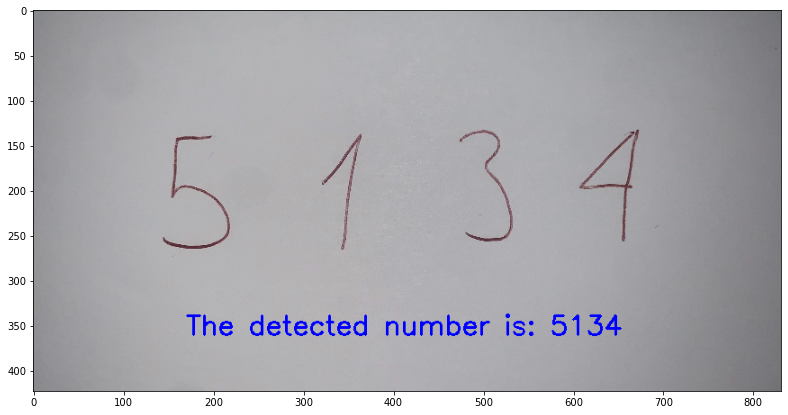

In [12]:
plt.figure(figsize=(20,7))
plt.imshow(number);